In [ ]:
# Install all necessary libraries
!pip install -q albumentations torch torchvision segmentation-models-pytorch mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# --- KAGGLE SETUP ---
from google.colab import files
import os

# Upload kaggle.json if it doesn't exist
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file.")
    files.upload()
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("Kaggle API token already exists.")

# --- DATA DOWNLOAD ---
!kaggle datasets download -d carlolepelaars/camvid
!unzip -q camvid.zip -d ./camvid
print("Setup and data download complete.")

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/carlolepelaars/camvid
License(s): CC-BY-NC-SA-4.0
 95% 549M/575M [00:01<00:00, 280MB/s]
100% 575M/575M [00:01<00:00, 366MB/s]
Setup and data download complete.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import os

In [ ]:
# Base path where the 'train', 'val', 'test' folders are
BASE_DATA_PATH = './camvid/CamVid/'

# We will use the 'train' and 'train_labels' folders to create our dataset
# and then split it ourselves into training and validation sets.
IMAGE_DIR = os.path.join(BASE_DATA_PATH, 'train')
MASK_DIR = os.path.join(BASE_DATA_PATH, 'train_labels')

# Correct path to the class dictionary file
CODES_PATH = os.path.join(BASE_DATA_PATH, 'class_dict.csv')

# --- CLASS LOADING ---
# The file is a standard CSV, so we read it with a comma separator.
# It also has a header row, so pandas can read the column names automatically.
class_df = pd.read_csv(CODES_PATH)

# The column names in the CSV are 'name', 'r', 'g', 'b'.
class_names = class_df['name'].tolist()
class_values = class_df[['r', 'g', 'b']].values

# Define image dimensions and other hyperparameters
IMG_HEIGHT, IMG_WIDTH = 256, 384
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Configuration and class dictionary loaded correctly.")

Configuration and class dictionary loaded correctly.


In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, mask_dir, class_values, augmentation=None, preprocessing=None):
        self.image_fnames = sorted(os.listdir(image_dir))
        self.image_dir, self.mask_dir = image_dir, mask_dir
        self.class_values = class_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, idx):
        img_fname = self.image_fnames[idx]
        img_path = os.path.join(self.image_dir, img_fname)
        mask_fname = img_fname.replace('.png', '_L.png')
        mask_path = os.path.join(self.mask_dir, mask_fname)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))

        semantic_map = np.zeros(mask.shape[:2], dtype=np.int64)
        for i, rgb in enumerate(self.class_values):
            equality = np.equal(mask, rgb)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = i

        if self.augmentation:
            augmented = self.augmentation(image=image, mask=semantic_map)
            image, mask = augmented['image'], augmented['mask']
        if self.preprocessing:
            processed = self.preprocessing(image=image, mask=mask)
            image, mask = processed['image'], processed['mask']

        return image, mask

In [ ]:
# AUGMENTATIONS
train_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

val_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
])

print("Setup Complete. All definitions are ready.")


Setup Complete. All definitions are ready.


In [ ]:
def train_model(model, model_name, encoder_name, epochs):
    """
    Trains a segmentation model, saves the best version, and returns the history.
    """
    print(f"--- Training {model_name} with {encoder_name} encoder ---")

    # Get preprocessing functions for the chosen encoder
    preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder_name, "imagenet")
    preprocessing = A.Compose([
        A.Lambda(image=preprocessing_fn),
        ToTensorV2(transpose_mask=True),
    ])

    # Create datasets and dataloaders
    full_dataset = CamVidDataset(IMAGE_DIR, MASK_DIR, class_values)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_dataset.dataset.augmentation = train_transform
    train_dataset.dataset.preprocessing = preprocessing
    val_dataset.dataset.augmentation = val_transform
    val_dataset.dataset.preprocessing = preprocessing

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Setup loss, optimizer, and history tracking
    loss_fn = smp.losses.DiceLoss(mode='multiclass')
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = {'train_loss': [], 'val_iou': []}
    best_iou = 0.0

    # Training loop
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0

        for data, targets in loop:
            data, targets = data.float().to(DEVICE), targets.long().to(DEVICE)
            optimizer.zero_grad()
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        total_iou = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.float().to(DEVICE), targets.long().to(DEVICE)
                preds = model(data)
                tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(preds, dim=1), targets, mode='multiclass', num_classes=len(class_names))
                iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
                total_iou += iou_score.item()

        avg_iou = total_iou / len(val_loader)
        avg_loss = epoch_loss / len(train_loader)

        history['train_loss'].append(avg_loss)
        history['val_iou'].append(avg_iou)

        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Val IoU: {avg_iou:.4f}")

        # Save the best model
        if avg_iou > best_iou:
            best_iou = avg_iou
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"✅ New best model saved to {model_name}_best.pth")

    print(f"--- Training complete for {model_name} ---")
    return history

In [ ]:
# Train Model 1: U-Net
unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(class_names),
).to(DEVICE)

unet_history = train_model(unet_model, "unet", "resnet34", epochs=EPOCHS)

--- Training unet with resnet34 encoder ---


Epoch 1/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.7402 | Val IoU: 0.2966
✅ New best model saved to unet_best.pth


Epoch 2/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.7103 | Val IoU: 0.3328
✅ New best model saved to unet_best.pth


Epoch 3/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.6782 | Val IoU: 0.5882
✅ New best model saved to unet_best.pth


Epoch 4/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.6635 | Val IoU: 0.6109
✅ New best model saved to unet_best.pth


Epoch 5/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.6418 | Val IoU: 0.6398
✅ New best model saved to unet_best.pth


Epoch 6/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.6330 | Val IoU: 0.6302


Epoch 7/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.6190 | Val IoU: 0.6604
✅ New best model saved to unet_best.pth


Epoch 8/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.6024 | Val IoU: 0.6699
✅ New best model saved to unet_best.pth


Epoch 9/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.5932 | Val IoU: 0.6960
✅ New best model saved to unet_best.pth


Epoch 10/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.5933 | Val IoU: 0.7042
✅ New best model saved to unet_best.pth


Epoch 11/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.5878 | Val IoU: 0.7070
✅ New best model saved to unet_best.pth


Epoch 12/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.5860 | Val IoU: 0.6939


Epoch 13/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.5761 | Val IoU: 0.7061


Epoch 14/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.5822 | Val IoU: 0.4165


Epoch 15/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.5795 | Val IoU: 0.4192


Epoch 16/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.5656 | Val IoU: 0.4149


Epoch 17/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.5525 | Val IoU: 0.4106


Epoch 18/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.5431 | Val IoU: 0.4157


Epoch 19/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.5290 | Val IoU: 0.4181


Epoch 20/20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.5153 | Val IoU: 0.4208
--- Training complete for unet ---


In [ ]:
# --- Train Model 2: DeepLabV3+ ---
deeplab_model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=len(class_names),
).to(DEVICE)

deeplab_history = train_model(deeplab_model, "deeplabv3plus", "resnet34", epochs=10)

--- Training deeplabv3plus with resnet34 encoder ---


Epoch 1/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.7147 | Val IoU: 0.5623
✅ New best model saved to deeplabv3plus_best.pth


Epoch 2/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.6364 | Val IoU: 0.6282
✅ New best model saved to deeplabv3plus_best.pth


Epoch 3/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.5953 | Val IoU: 0.6606
✅ New best model saved to deeplabv3plus_best.pth


Epoch 4/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.5735 | Val IoU: 0.6839
✅ New best model saved to deeplabv3plus_best.pth


Epoch 5/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.5481 | Val IoU: 0.6954
✅ New best model saved to deeplabv3plus_best.pth


Epoch 6/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.5381 | Val IoU: 0.7012
✅ New best model saved to deeplabv3plus_best.pth


Epoch 7/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.5166 | Val IoU: 0.7063
✅ New best model saved to deeplabv3plus_best.pth


Epoch 8/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.4904 | Val IoU: 0.7294
✅ New best model saved to deeplabv3plus_best.pth


Epoch 9/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.4724 | Val IoU: 0.7382
✅ New best model saved to deeplabv3plus_best.pth


Epoch 10/10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.4443 | Val IoU: 0.7460
✅ New best model saved to deeplabv3plus_best.pth
--- Training complete for deeplabv3plus ---


In [ ]:
# Compare the Results

# Get the best IoU score achieved by each model during training
best_unet_iou = max(unet_history['val_iou'])
best_deeplab_iou = max(deeplab_history['val_iou'])

# Get the final training loss for each model
final_unet_loss = unet_history['train_loss'][-1]
final_deeplab_loss = deeplab_history['train_loss'][-1]

# Create a pandas DataFrame for a nice-looking table
comparison_data = {
    "Model": ["U-Net", "DeepLabV3+"],
    "Best Validation IoU": [f"{best_unet_iou:.4f}", f"{best_deeplab_iou:.4f}"],
    "Final Training Loss": [f"{final_unet_loss:.4f}", f"{final_deeplab_loss:.4f}"]
}
results_df = pd.DataFrame(comparison_data)

print("--- Model Comparison ---")
print(results_df)

# Declare the winner based on IoU
winner = "U-Net" if best_unet_iou > best_deeplab_iou else "DeepLabV3+"
print(f"\nThe winner is: {winner}")

--- Model Comparison ---
        Model Best Validation IoU Final Training Loss
0       U-Net              0.7070              0.5153
1  DeepLabV3+              0.7460              0.4443

The winner is: DeepLabV3+


Loaded weights from deeplabv3plus_best.pth


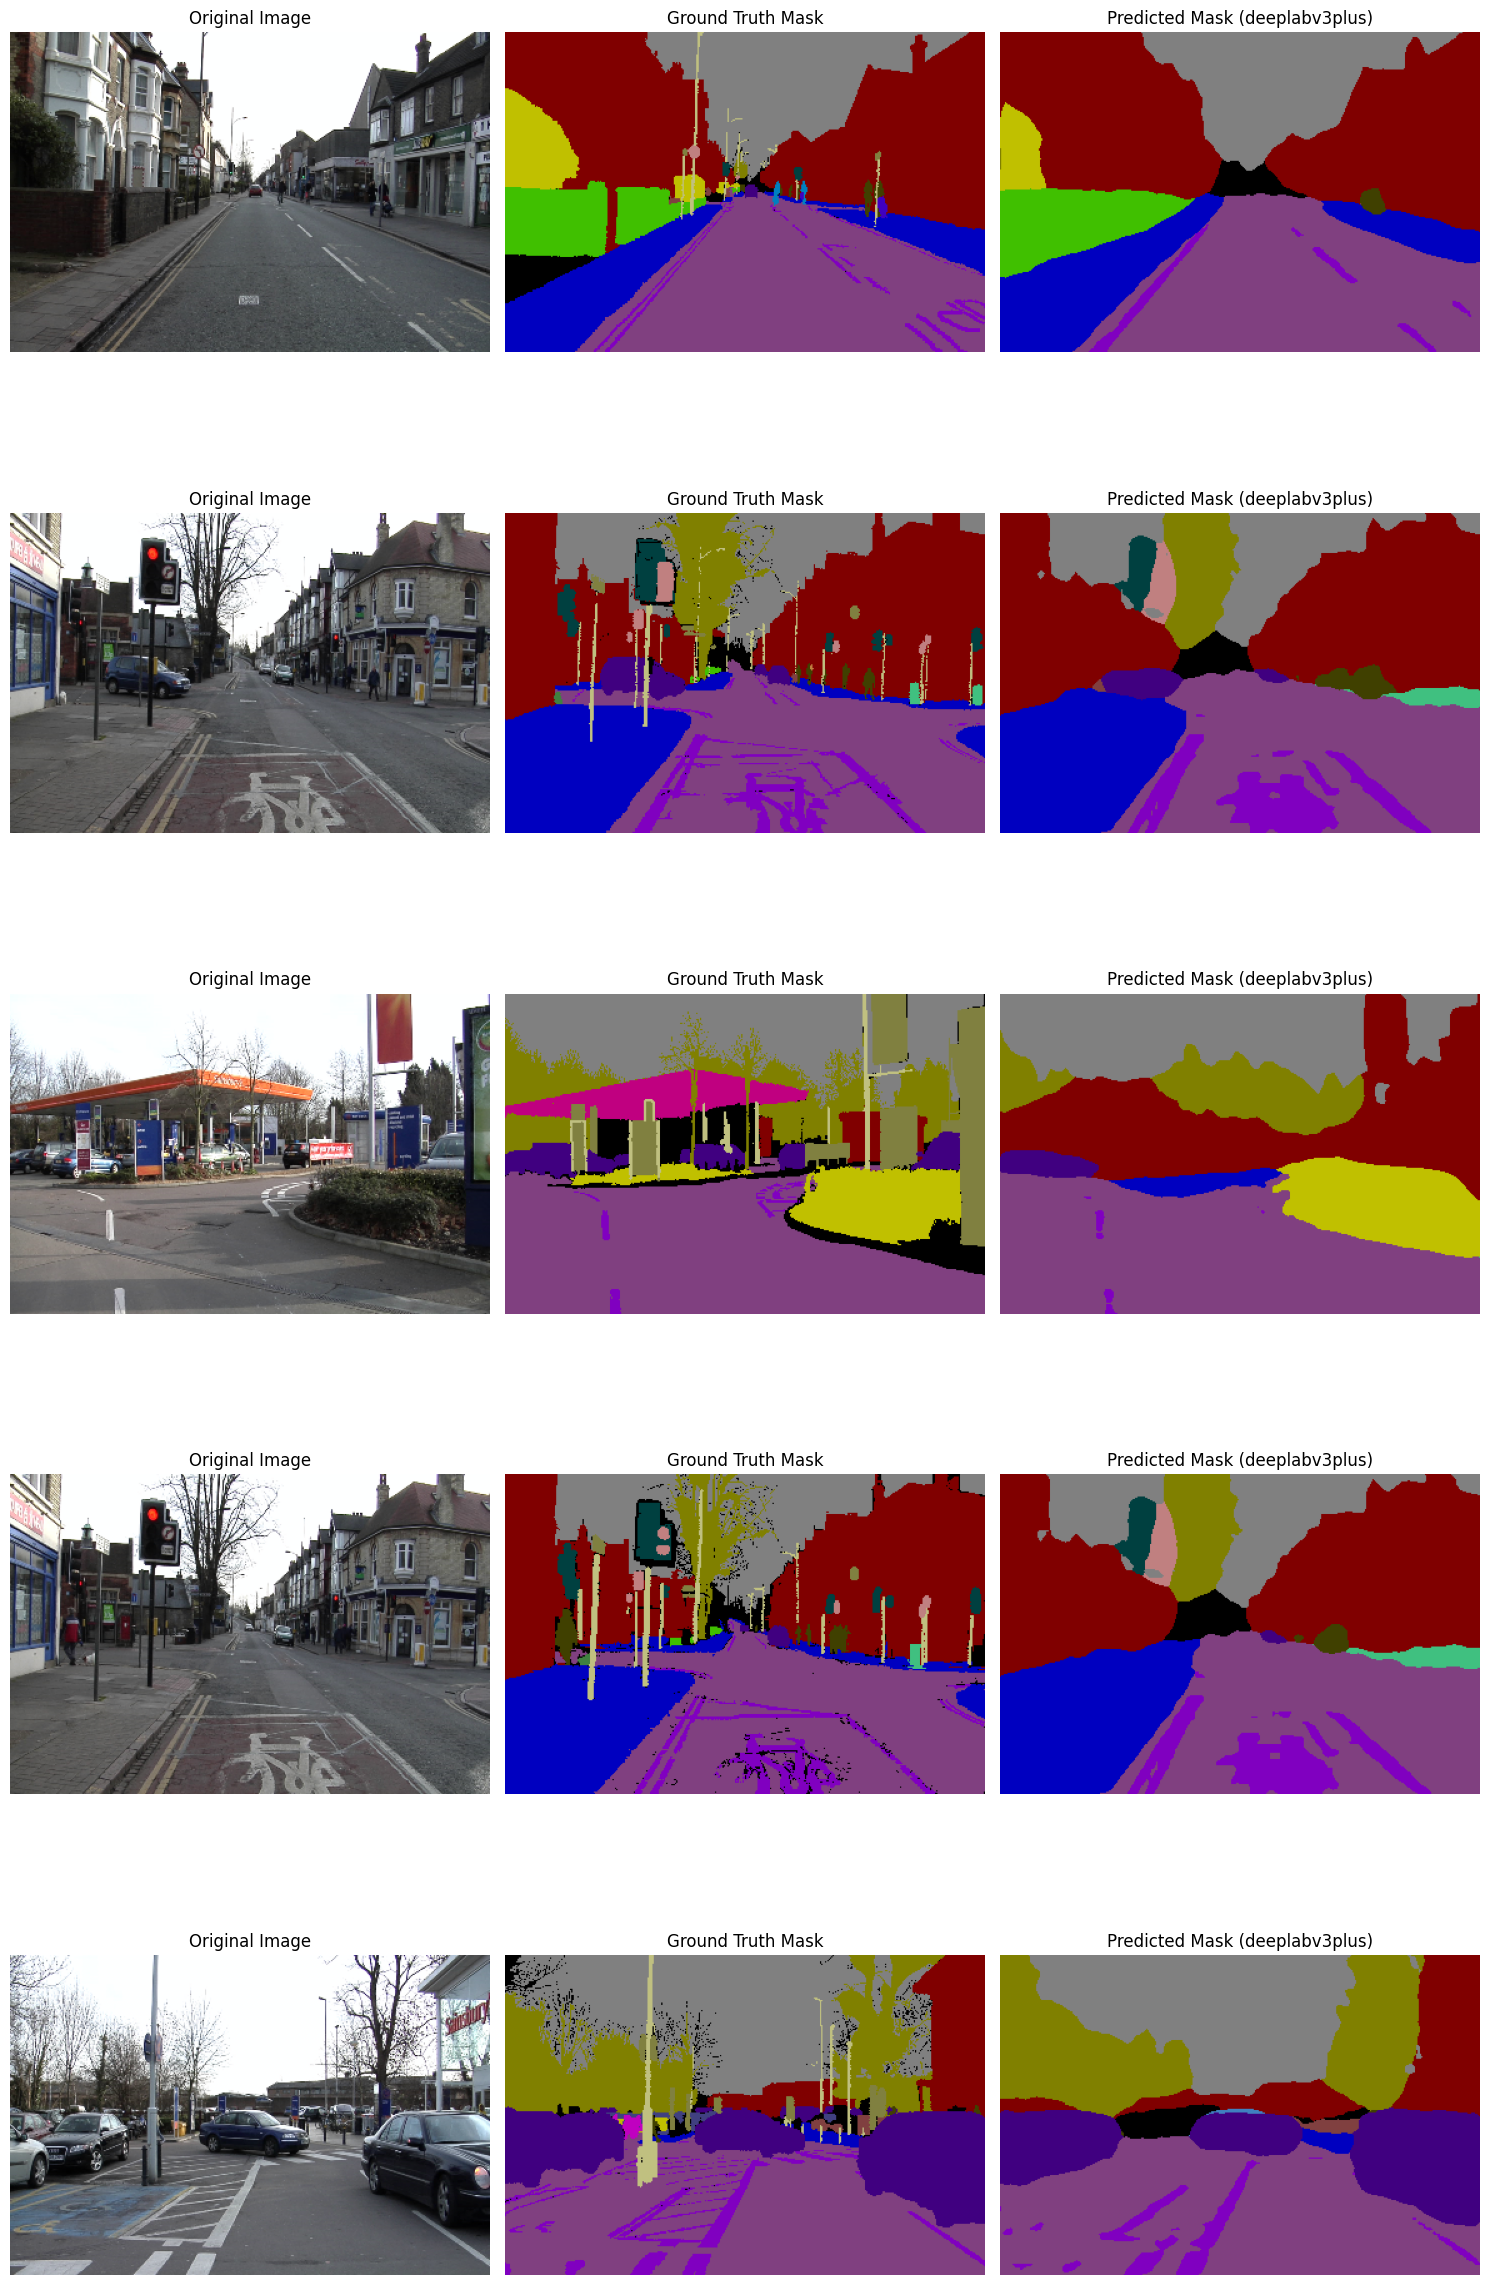

In [ ]:
# --- Visualize Predictions from the Winning Model ---

WINNING_MODEL_NAME = "deeplabv3plus" # Change this to 'unet' if it won

# We need to create an instance of the model architecture first
if WINNING_MODEL_NAME == "unet":
    winner_model_arch = smp.Unet(encoder_name="resnet34", in_channels=3, classes=len(class_names)).to(DEVICE)
else:
    winner_model_arch = smp.DeepLabV3Plus(encoder_name="resnet34", in_channels=3, classes=len(class_names)).to(DEVICE)

# Now, load the saved weights from the file
model_path = f"{WINNING_MODEL_NAME}_best.pth"
winner_model_arch.load_state_dict(torch.load(model_path))
print(f"Loaded weights from {model_path}")


# The visualization function (you can define this in Cell 1)
def mask_to_rgb(mask, color_values):
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for i, color in enumerate(color_values):
        rgb_mask[mask == i] = color
    return rgb_mask

def visualize_predictions(model, num_images=5):
    # Setup a new dataloader just for visualization
    preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet34", "imagenet")
    preprocessing = A.Compose([A.Lambda(image=preprocessing_fn), ToTensorV2(transpose_mask=True)])

    viz_dataset = CamVidDataset(os.path.join(BASE_DATA_PATH, 'val'), os.path.join(BASE_DATA_PATH, 'val_labels'), class_values, augmentation=val_transform, preprocessing=preprocessing)
    viz_loader = DataLoader(viz_dataset, batch_size=num_images, shuffle=True)

    model.eval()
    images, masks = next(iter(viz_loader))
    images = images.float().to(DEVICE)

    with torch.no_grad():
        preds = model(images)
        pred_masks = torch.argmax(preds, dim=1)

    images_cpu, masks_cpu, pred_masks_cpu = images.cpu(), masks.cpu(), pred_masks.cpu()
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(15, num_images * 5))
    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 3, i * 3 + 1)
        img_display = images_cpu[i].permute(1, 2, 0).numpy()
        img_display = std * img_display + mean
        plt.imshow(np.clip(img_display, 0, 1))
        plt.title("Original Image"); plt.axis("off")

        # Ground Truth Mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(mask_to_rgb(masks_cpu[i].squeeze().numpy(), class_values))
        plt.title("Ground Truth Mask"); plt.axis("off")

        # Predicted Mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(mask_to_rgb(pred_masks_cpu[i].numpy(), class_values))
        plt.title(f"Predicted Mask ({WINNING_MODEL_NAME})"); plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_predictions(winner_model_arch)